### Using ancillary data

Wherein we align and cut out the relevant area from other images, and demonstrate an adaptive binning method.

The first step is to set up the directories. You'll need somewhere to store the ouput.

In [1]:
from pathlib import Path
import yaml
import os

# Or similar
root_dir = Path(os.getenv("ROOT_DIR"))

# Wherever the original mosaics are saved
orig_mosaic_dir = root_dir / "archival" / "grizli-v2" / "JwstMosaics" / "v7"

# Your new favourite directory
out_base_dir = root_dir / "2024_08_16_A2744_v4" / "glass_niriss_hires"
out_base_dir.mkdir(exist_ok=True, parents=True)

We then need to parse all of the imaging mosaics. We need to have some record of:
* Which combination of telescope, instrument, and filter corresponds to each image.
* The type of each image - science, weight, exposure, variance.

If your imaging mosaics follow the Grizli AWS / DJA format, there's an automated function to parse this information from a directory. We can also loop over each instrument/filter key to calculate the full variance mosaic (including the poisson noise).

<div class="alert alert-warning">

**Warning:**

Calculating the full variance array can require a significant amount of memory and disk space, particularly if the mosaics are very large, or are stored in compressed ".fits.gz" format. Even parsing information from the FITS header can take a long time if the files are compressed.

</div>


In [2]:
# Where to save the details
obs_dict_path = out_base_dir / "full_ancillary_data.yaml"

# Avoid parsing files again if the details already exist 
if obs_dict_path.is_file():
    
    with open(obs_dict_path, "r") as file:
        obs_dict = yaml.safe_load(file)

else:

    from glass_niriss.pipeline import parse_files_grizli_aws

    obs_dict = parse_files_grizli_aws(
        orig_mosaic_dir, out_path=out_base_dir / "full_ancillary_data.yaml"
    )

In [3]:
# # Check that a variance array exists for all science images
# for k, v in obs_dict.items():
#     if v.get("var") is None:
#         try:
#             var_path = Path(v["exp"]["path"].replace("_exp", "_var"))
#             assert var_path.is_file(), "var does not exist" 
#         except:
#             print (f"Generating var for {k}...")
            
#             from glass_niriss.isophotal import calc_full_var

#             try:
#                 var_path = calc_full_var(
#                     sci_path=v["sci"]["path"], wht_path=v["wht"]["path"],
#                     exp_path=v["exp"]["path"]
#                 )
#                 obs_dict[k]["var"] = {
#                     "path" : str(var_path),
#                     "version" : v["exp"]["version"],
#                     "flag_incomplete" : v["exp"]["flag_incomplete"]
#                 }
#             except:
#                 print (f"Failed to generate var for {k}")

# with open(obs_dict_path, "w") as outfile:
#     yaml.dump(obs_dict, outfile, default_flow_style=False, sort_keys=False)

Before we can start using these images, we want to make sure they're all aligned, at the right pixel scale, and with the same point-spread function (PSF). To do this, we need to know the PSF of each individual image. Deriving this is not (currently) part of the ``glass-niriss`` package, although PSFs for the A2744 field are included under ``data/psfs``. Some packages and useful references for deriving PSFs include [aperpy](https://github.com/astrowhit/aperpy), [photutils](https://photutils.readthedocs.io), and [PSFEx](https://psfex.readthedocs.io).

Opening ``"full_ancillary_data.yaml"`` in any suitable text editor, you'll notice there's an empty field marked ``psf`` for each filter key. Simply copy and paste the path to the relevant PSF here, and then carry on running the pipeline.

<div class="alert alert-warning">

**Warning:**

As before, the reprojection and convolution **will** require a significant amount of memory and disk space. Depending on how many filters you have, it could also take a couple hours (*eg* A2744: 38 filters, 43k x 35k mosaics -> 1.2 hours). The good news is, you only have to run this code block once.

</div>

In [4]:
from glass_niriss.isophotal import reproject_and_convolve

# Reload the full obs dict with PSF info
with open(obs_dict_path, "r") as file:
    obs_dict = yaml.safe_load(file)

# Where to save the details of the PSF-matched images
conv_dict_path = out_base_dir / "conv_ancillary_data.yaml"

# Where to save the reprojected and convolved images
conv_out_dir = out_base_dir / "PSF_matched_data"

# The reference mosaic to align the images to
ref_mosaic = (
    out_base_dir.parent / "grizli_home" / "Prep" / "glass-a2744-ir_drc_sci.fits"
)

# Avoid parsing files again if the details already exist 
if conv_dict_path.is_file():

    with open(conv_dict_path, "r") as file:
        conv_dict = yaml.safe_load(file)

else:
    conv_dict = {}
    for filt_key, old_details in obs_dict.items():
        conv_dict[filt_key] = {
            k: v for k, v in old_details.items() 
            if k not in ["exp","sci","var","wht"]
        }

        for t in ["sci","var"]:
            _conv_out_path = reproject_and_convolve(
                ref_path=ref_mosaic,
                orig_images=Path(obs_dict[filt_key][t]["path"]),
                psfs=Path(obs_dict[filt_key]["psf"]),
                psf_target=obs_dict["jwst-nircam-f200w"]["psf"],
                out_dir=conv_out_dir,
                new_names=f"repr_{filt_key}_{t}.fits",
                reproject_image_kw={"method": "adaptive", "compress": False,},
            )

            conv_dict[filt_key][t] = str(_conv_out_path[0])

    with open(conv_dict_path, "w") as outfile:
        yaml.dump(conv_dict, outfile, default_flow_style=False, sort_keys=False)

print (conv_dict)

/media/sharedData/data/2024_08_16_A2744_v4/glass_niriss_hires/PSF_matched_data/repr_hst-acs-f435w_sci.fits
'repr_hst-acs-f435w_sci.fits' already exists. Set `overwrite=True` if you wish to overwrite this file.
'conv_hst-acs-f435w_sci.fits' already exists. Skipping.
/media/sharedData/data/2024_08_16_A2744_v4/glass_niriss_hires/PSF_matched_data/repr_hst-acs-f435w_var.fits
'repr_hst-acs-f435w_var.fits' already exists. Set `overwrite=True` if you wish to overwrite this file.
'conv_hst-acs-f435w_var.fits' already exists. Skipping.
/media/sharedData/data/2024_08_16_A2744_v4/glass_niriss_hires/PSF_matched_data/repr_hst-acs-f606w_sci.fits
'repr_hst-acs-f606w_sci.fits' already exists. Set `overwrite=True` if you wish to overwrite this file.
'conv_hst-acs-f606w_sci.fits' already exists. Skipping.
/media/sharedData/data/2024_08_16_A2744_v4/glass_niriss_hires/PSF_matched_data/repr_hst-acs-f606w_var.fits
'repr_hst-acs-f606w_var.fits' already exists. Set `overwrite=True` if you wish to overwrite thi

We now have a directory of flux and variance images, PSF-matched to our largest PSF, and aligned to a consistent pixel scale. Let's do the same to our segmentation map.

In [5]:
# The path of the original segmentation map
orig_seg = out_base_dir.parent / "grizli_home" / "ForcedExtractions" / "glass-a2744-ir_seg_5_renumbered_test_2.fits"

reproject_and_convolve(
    ref_path=ref_mosaic,
    orig_images=orig_seg,
    psfs=None,
    psf_target=None,
    out_dir=conv_out_dir,
    new_names=f"repr_glass-a2744-ir_seg.fits",
    reproject_image_kw={"method": "interp", "order": 0, "compress" : False},
)

repr_seg_path = conv_out_dir / "repr_glass-a2744-ir_seg.fits"

/media/sharedData/data/2024_08_16_A2744_v4/glass_niriss_hires/PSF_matched_data/repr_glass-a2744-ir_seg.fits
Opened
Updated header
Using buffer
About to reproject


That's everything we need to start deriving spatially-resolved SEDs. Let's pull out an interesting object to look at.

There's many different ways to go about this. Some authors prefer to fit every pixel, some perform an adaptive binning across the whole image to ensure a minimum signal/noise (S/N). For very large galaxies, there's a ``constrained_adaptive()`` function, where the initial binning is done in a hexagonal pattern, and any remaining pixels are run through an adaptive Voronoi binning scheme. This can ensure a minimum bin size (avoiding significant oversampling of the PSF), as well as reducing the number of bins to fit.

For this particular galaxy, given its small size, we just run through a Voronoi binning method ``constrained_adaptive(..., use_hex=False)``. We aim for a S/N of 100, and mask out pixels that aren't included in the segmentation map for this object.

And finally, we can save the segmentation map, along with the binned data for all filters.

If you're working with multiple objects, there's also a convenient wrapper for these operations. Using a slightly different object:

Skipping hex bin
Bin-accretion...
1  /  250
2  /  250
3  /  250
4  /  250
5  /  250
6  /  250
7  /  250
8  /  250
9  /  250
10  /  250
11  /  250
12  /  250
13  /  250
14  /  250
15  /  250
16  /  250
17  /  250
18  /  250
19  /  250
20  /  250
21  /  250
22  /  250
23  /  250
24  /  250
25  /  250
26  /  250
27  /  250
28  /  250
29  /  250
30  /  250
31  /  250
32  /  250
33  /  250
34  /  250
35  /  250
36  /  250
37  /  250
38  /  250
39  /  250
40  /  250
41  /  250
42  /  250
43  /  250
44  /  250
45  /  250
46  /  250
47  /  250
48  /  250
49  /  250
50  /  250
51  /  250
52  /  250
53  /  250
54  /  250
55  /  250
56  /  250
57  /  250
58  /  250
59  /  250
60  /  250
61  /  250
62  /  250
63  /  250
64  /  250
65  /  250
66  /  250
67  /  250
68  /  250
69  /  250
70  /  250
71  /  250
72  /  250
73  /  250
74  /  250
75  /  250
76  /  250
77  /  250
78  /  250
79  /  250
80  /  250
81  /  250
82  /  250
83  /  250
84  /  250
85  /  250
86  /  250
87  /  250
88  /  250
89  /  

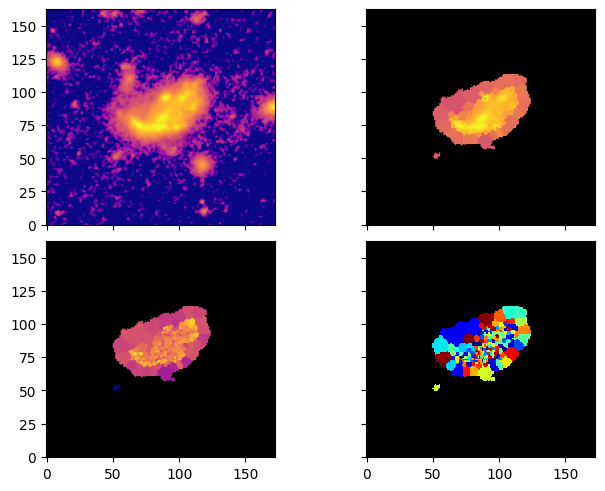

PosixPath('/media/sharedData/data/2024_08_16_A2744_v4/glass_niriss_hires/binned_data/2663_vorbin_3_50_jwst-nircam-f200w_data.fits')

In [7]:
# Make a new directory for the binned data
bin_data_dir = out_base_dir / "binned_data"
bin_data_dir.mkdir(exist_ok=True, parents=True)


# Test things work
from glass_niriss.sed import bin_and_save

bin_and_save(
    obj_id = 2663,
    out_dir = bin_data_dir,
    seg_map = repr_seg_path,
    info_dict = conv_dict,
    sn_filter = "jwst-nircam-f200w",
    target_sn=50,
    bin_diameter=3,
    use_hex=False,
    overwrite=True
)